In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ezc3d import c3d
from scipy.signal import resample
from scipy.io import loadmat, savemat
from joblib import load, dump
from tqdm import tqdm
from scipy.signal import butter, lfilter

# Constants

In [2]:
PATH_DATASETS = '../../Dataset/'
PATH_DATASET_2 = 'gait-dbase-2/'

N_SAMPLES = 1024
FORCE_THRESHOLD = 20
TOE_HEIGTH_THRESHOLD = 40

# Filter

In [3]:
class LowPassFilter(object): 
    @staticmethod
    def butter_lowpass(cutoff, fs, order):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def apply(data, cutoff=6, fs=2000, order=2, axis=-1):
        b, a = LowPassFilter.butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data, axis=axis)
        y = y - np.median(y)
        return y

# Function Defs

In [4]:
def standardize(x):
    # return (x - np.mean(x, axis=0)) / np.std(x, axis=0)
    return (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))

def require_positive(x):
    if x < 0:
        return 0
    else:
        return x

def clip_overflow(x, max=N_SAMPLES):
    if x >= max:
        return N_SAMPLES - 1
    else:
        return x

def clip_noise(x, min=FORCE_THRESHOLD):
    mask = x > min
    new_x = np.zeros(x.shape)
    new_x[mask] = x[mask]
    return new_x

def get_first_grf(x, swing_period):
    half_way = x.shape[0] / 2
    temp = np.zeros(x.shape)
    temp[:half_way] = x[:half_way]
    stance_mask = temp < FORCE_THRESHOLD
    stance_start = np.min(stance_mask == True)
    stance_end = np.max(stance_mask == True)
    roi_start = stance_start
    roi_end = stance_end + swing_period
    return temp[roi_start : roi_end]

def get_processed_grf(grf, clip=False):
    processed_grf = LowPassFilter.apply(grf, fs=2000, cutoff=20)
    if clip:
        processed_grf[processed_grf < FORCE_THRESHOLD] = 0
    return resample(processed_grf, N_SAMPLES * 4, axis=0).T
    

In [5]:
def get_trajectories(content, foot='right'):
    if foot == 'right':
        trajectory_x = content['data']['points'][0, 12:24, :]
        trajectory_y = content['data']['points'][1, 12:24, :]
        trajectory_z = content['data']['points'][2, 12:24, :]

    elif foot == 'left':
        trajectory_x = content['data']['points'][0, 0:12, :]
        trajectory_y = content['data']['points'][1, 0:12, :]
        trajectory_z = content['data']['points'][2, 0:12, :]

    else:
        raise ValueError('Third foot is not allowed')

    # trajectory_x = LowPassFilter.apply(trajectory_x, fs=200, cutoff=20)
    # trajectory_y = LowPassFilter.apply(trajectory_y, fs=200, cutoff=20)
    # trajectory_z = LowPassFilter.apply(trajectory_z, fs=200, cutoff=20)

    trajectory_x = resample(trajectory_x, N_SAMPLES * 4, axis=1).T
    trajectory_y = resample(trajectory_y, N_SAMPLES * 4, axis=1).T
    trajectory_z = resample(trajectory_z, N_SAMPLES * 4, axis=1).T

    return trajectory_x, trajectory_y, trajectory_z

def get_force_plate_data(content):
    force_plate_data_x = []
    force_plate_data_y = []
    force_plate_data_z = []
    for i in range(1, 5):
        force_plate_data_x.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][0, :]
            )
        )
        force_plate_data_y.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][1, :]
            )
        )
        force_plate_data_z.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][2, :], True
            )
        )

    return force_plate_data_x, force_plate_data_y, force_plate_data_z

def get_swing_period(force_plate_data_z):
    grf_combined_z_r = force_plate_data_z[0] + force_plate_data_z[2]
    grf_combined_z_l = force_plate_data_z[1] + force_plate_data_z[3]

    grf_mask_r = (grf_combined_z_r >= FORCE_THRESHOLD)
    grf_mask_l = (grf_combined_z_l >= FORCE_THRESHOLD)

    grf_start_r = np.min(np.argwhere(grf_mask_r == True))
    grf_end_r = np.max(np.argwhere(grf_mask_r == True))
    grf_start_l = np.min(np.argwhere(grf_mask_l == True))
    grf_end_l = np.max(np.argwhere(grf_mask_l == True))

    swing_period_r = np.sum(grf_combined_z_r[grf_start_r:grf_end_r] <= FORCE_THRESHOLD)
    swing_period_l = np.sum(grf_combined_z_l[grf_start_l:grf_end_l] <= FORCE_THRESHOLD)

    return swing_period_r, swing_period_l
    

# Test Bench

In [6]:
path = '/home/ai/Python/GRF-Synthesis-from-Motion-Trajectories/Dataset/gait-dbase-2/Participant3/Raw_Data/V35/T1.c3d'

In [7]:
content = c3d(path, extract_forceplat_data=True)

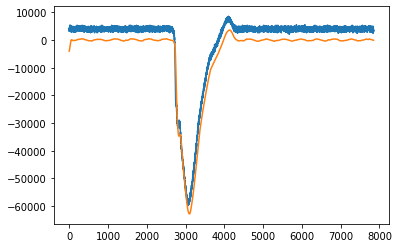

In [8]:
z = content['data']['platform'][2]['moment'][0]
f = LowPassFilter.apply(z, cutoff=20, fs=2000, order=2)
plt.plot(z)
plt.plot(f)

In [9]:
trajectory_x_r, trajectory_y_r, trajectory_z_r = get_trajectories(content, 'right')
trajectory_x_l, trajectory_y_l, trajectory_z_l = get_trajectories(content, 'left')

force_x, force_y, force_z = get_force_plate_data(content)
# swing_period_r, swing_period_l = get_swing_period(force_z)

In [10]:
sum(force_z).shape

(4096,)

In [11]:
trajectory_z_r.shape

(4096, 12)

In [12]:
filtered = LowPassFilter.apply(force_x, cutoff=20, fs=2000)

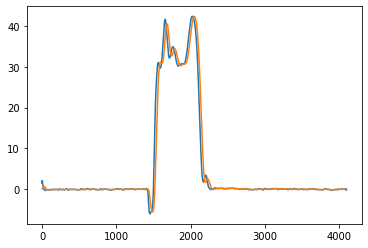

In [13]:
plt.plot(force_x[1])
plt.plot(filtered[1])

In [14]:
filtered.shape

(4, 4096)

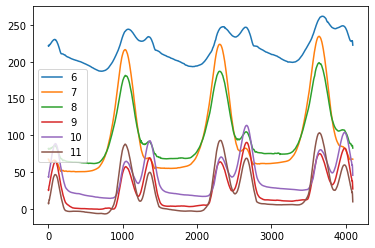

In [15]:
for i in range(6, 12):
    plt.plot(trajectory_z_r[:, i], label=f"{i}")
plt.legend()

(4096, 12)

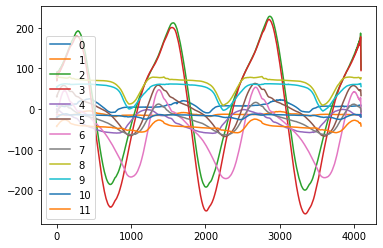

In [16]:
d_trajectory_y_r = np.gradient(trajectory_y_r, axis=-1)
for i in range(12):
    plt.plot(d_trajectory_y_r[:, i], label=f"{i}")
plt.legend()
d_trajectory_y_r.shape

(4096, 12)

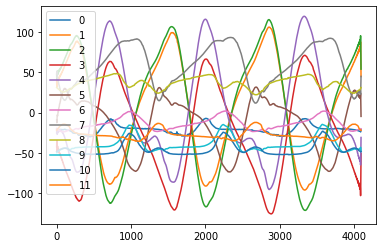

In [17]:
dd_trajectory_y_r = np.gradient(d_trajectory_y_r, axis=-1)
for i in range(12):
    plt.plot(dd_trajectory_y_r[:, i], label=f"{i}")
plt.legend()
dd_trajectory_y_r.shape

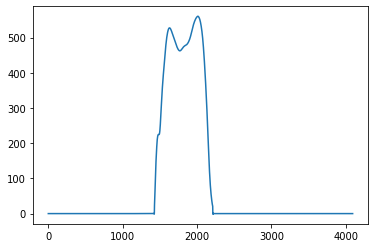

In [18]:
plt.plot(force_z[1])

# Extract Features

In [19]:
path = os.path.join(PATH_DATASETS, PATH_DATASET_2)
subjects = os.listdir(path)

subjects = subjects[8:]

features = pd.DataFrame()
target = pd.DataFrame()

records = []
n_samples = 0
n_bad_samples = 0

for subject in tqdm(subjects):
    velocities_path = os.path.join(path, subject, 'Raw_Data')
    velocities = os.listdir(velocities_path)

    for velocity in velocities:

        files_path = os.path.join(velocities_path, velocity)
        files = os.listdir(files_path)

        for filename in files:
            try:
                content = c3d(os.path.join(files_path, filename), extract_forceplat_data=True)
                
                trajectory_x_r, trajectory_y_r, trajectory_z_r = get_trajectories(content, 'right')
                trajectory_x_l, trajectory_y_l, trajectory_z_l = get_trajectories(content, 'left')

                force_x, force_y, force_z = get_force_plate_data(content)
                swing_period_r, swing_period_l = get_swing_period(force_z)

                mask_force_z_r_1 = (force_z[0] > FORCE_THRESHOLD)
                mask_force_z_r_2 = (force_z[2] > FORCE_THRESHOLD)
                mask_force_z_l_1 = (force_z[1] > FORCE_THRESHOLD)
                mask_force_z_l_2 = (force_z[3] > FORCE_THRESHOLD)

                # ----------------------- RIGHT ------------------------

                start = np.min(np.argwhere(mask_force_z_r_1 == True))
                end = np.max(np.argwhere(mask_force_z_r_1 == True)) # + swing_period_r

                force_x_r_1 = force_x[0][start : end]
                force_y_r_1 = force_y[0][start : end]
                force_z_r_1 = force_z[0][start : end]

                trajectory_x_r_1 = trajectory_x_r[start:end]
                trajectory_y_r_1 = trajectory_y_r[start:end]
                trajectory_z_r_1 = trajectory_z_r[start:end]

                start = np.min(np.argwhere(mask_force_z_r_2 == True))
                end = np.max(np.argwhere(mask_force_z_r_2 == True)) # + swing_period_r

                force_x_r_2 = force_x[2][start : end]
                force_y_r_2 = force_y[2][start : end]
                force_z_r_2 = force_z[2][start : end]

                trajectory_x_r_2 = trajectory_x_r[start:end]
                trajectory_y_r_2 = trajectory_y_r[start:end]
                trajectory_z_r_2 = trajectory_z_r[start:end]


                # ----------------------- LEFT ------------------------

                start = np.min(np.argwhere(mask_force_z_l_1 == True))
                end = np.max(np.argwhere(mask_force_z_l_1 == True)) # + swing_period_l

                force_x_l_1 = force_x[1][start : end]
                force_y_l_1 = force_y[1][start : end]
                force_z_l_1 = force_z[1][start : end]

                trajectory_x_l_1 = trajectory_x_l[start:end]
                trajectory_y_l_1 = trajectory_y_l[start:end]
                trajectory_z_l_1 = trajectory_z_l[start:end]

                start = np.min(np.argwhere(mask_force_z_l_2 == True))
                end = np.max(np.argwhere(mask_force_z_l_2 == True)) # + swing_period_l

                force_x_l_2 = force_x[3][start : end]
                force_y_l_2 = force_y[3][start : end]
                force_z_l_2 = force_z[3][start : end]

                trajectory_x_l_2 = trajectory_x_l[start:end]
                trajectory_y_l_2 = trajectory_y_l[start:end]
                trajectory_z_l_2 = trajectory_z_l[start:end]


                # ... Remove all zero GRF samples
                # if np.mean(force_z_2) <= FORCE_THRESHOLD or np.mean(force_z_3) <= FORCE_THRESHOLD \
                #     or np.mean(force_z_4) <= FORCE_THRESHOLD or np.mean(force_z_5) <= FORCE_THRESHOLD:
                #     n_bad_samples = n_bad_samples + 1
                #     continue

                
                # ... Resample
                force_x_r_1 = resample(force_x_r_1, N_SAMPLES, axis=0)
                force_x_l_1 = resample(force_x_l_1, N_SAMPLES, axis=0)
                force_x_r_2 = resample(force_x_r_2, N_SAMPLES, axis=0)
                force_x_l_2 = resample(force_x_l_2, N_SAMPLES, axis=0)

                force_y_r_1 = resample(force_y_r_1, N_SAMPLES, axis=0)
                force_y_l_1 = resample(force_y_l_1, N_SAMPLES, axis=0)
                force_y_r_2 = resample(force_y_r_2, N_SAMPLES, axis=0)
                force_y_l_2 = resample(force_y_l_2, N_SAMPLES, axis=0)

                force_z_r_1 = resample(force_z_r_1, N_SAMPLES, axis=0)
                force_z_l_1 = resample(force_z_l_1, N_SAMPLES, axis=0)
                force_z_r_2 = resample(force_z_r_2, N_SAMPLES, axis=0)
                force_z_l_2 = resample(force_z_l_2, N_SAMPLES, axis=0)

                trajectory_x_r_1 = resample(trajectory_x_r_1, N_SAMPLES, axis=0)
                trajectory_x_r_2 = resample(trajectory_x_r_2, N_SAMPLES, axis=0)
                trajectory_x_l_1 = resample(trajectory_x_l_1, N_SAMPLES, axis=0)
                trajectory_x_l_2 = resample(trajectory_x_l_2, N_SAMPLES, axis=0)

                trajectory_y_r_1 = resample(trajectory_y_r_1, N_SAMPLES, axis=0)
                trajectory_y_r_2 = resample(trajectory_y_r_2, N_SAMPLES, axis=0)
                trajectory_y_l_1 = resample(trajectory_y_l_1, N_SAMPLES, axis=0)
                trajectory_y_l_2 = resample(trajectory_y_l_2, N_SAMPLES, axis=0)

                trajectory_z_r_1 = resample(trajectory_z_r_1, N_SAMPLES, axis=0)
                trajectory_z_r_2 = resample(trajectory_z_r_2, N_SAMPLES, axis=0)
                trajectory_z_l_1 = resample(trajectory_z_l_1, N_SAMPLES, axis=0)
                trajectory_z_l_2 = resample(trajectory_z_l_2, N_SAMPLES, axis=0)

                # ... Standardize
                force_x_r_1 = standardize(force_x_r_1)
                force_x_l_1 = standardize(force_x_l_1)
                force_x_r_2 = standardize(force_x_r_2)
                force_x_l_2 = standardize(force_x_l_2)

                force_y_r_1 = standardize(force_y_r_1)
                force_y_l_1 = standardize(force_y_l_1)
                force_y_r_2 = standardize(force_y_r_2)
                force_y_l_2 = standardize(force_y_l_2)

                force_z_r_1 = standardize(force_z_r_1)
                force_z_l_1 = standardize(force_z_l_1)
                force_z_r_2 = standardize(force_z_r_2)
                force_z_l_2 = standardize(force_z_l_2)

                trajectory_x_r_1 = standardize(trajectory_x_r_1)
                trajectory_x_r_2 = standardize(trajectory_x_r_2)
                trajectory_x_l_1 = standardize(trajectory_x_l_1)
                trajectory_x_l_2 = standardize(trajectory_x_l_2)

                trajectory_y_r_1 = standardize(trajectory_y_r_1)
                trajectory_y_r_2 = standardize(trajectory_y_r_2)
                trajectory_y_l_1 = standardize(trajectory_y_l_1)
                trajectory_y_l_2 = standardize(trajectory_y_l_2)

                trajectory_z_r_1 = standardize(trajectory_z_r_1)
                trajectory_z_r_2 = standardize(trajectory_z_r_2)
                trajectory_z_l_1 = standardize(trajectory_z_l_1)
                trajectory_z_l_2 = standardize(trajectory_z_l_2)

                _features_l_1 = pd.DataFrame(
                    np.concatenate([trajectory_x_l_1, trajectory_y_l_1, trajectory_z_l_1], axis=1),
                    columns=[
                        '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x',
                        '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '7_y', '8_y', '9_y', '10_y', '11_y',
                        '0_z', '1_z', '2_z', '3_z', '4_z', '5_z', '6_z', '7_z', '8_z', '9_z', '10_z', '11_z'
                    ]
                )

                _features_l_2 = pd.DataFrame(
                    np.concatenate([trajectory_x_l_2, trajectory_y_l_2, trajectory_z_l_2], axis=1),
                    columns=[
                        '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x',
                        '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '7_y', '8_y', '9_y', '10_y', '11_y',
                        '0_z', '1_z', '2_z', '3_z', '4_z', '5_z', '6_z', '7_z', '8_z', '9_z', '10_z', '11_z'
                    ]
                )

                _features_r_1 = pd.DataFrame(
                    np.concatenate([trajectory_x_r_1, trajectory_y_r_1, trajectory_z_r_1], axis=1),
                    columns=[
                        '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x',
                        '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '7_y', '8_y', '9_y', '10_y', '11_y',
                        '0_z', '1_z', '2_z', '3_z', '4_z', '5_z', '6_z', '7_z', '8_z', '9_z', '10_z', '11_z'
                    ]
                )

                _features_r_2 = pd.DataFrame(
                    np.concatenate([trajectory_x_r_2, trajectory_y_r_2, trajectory_z_r_2], axis=1),
                    columns=[
                        '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x',
                        '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '7_y', '8_y', '9_y', '10_y', '11_y',
                        '0_z', '1_z', '2_z', '3_z', '4_z', '5_z', '6_z', '7_z', '8_z', '9_z', '10_z', '11_z'
                    ]
                )

                _features = pd.concat([_features_l_1, _features_l_2, _features_r_1, _features_r_2], axis=0)

                _target_r_1 = pd.DataFrame(
                    np.stack([force_x_r_1, force_y_r_1, force_z_r_1], axis=1),
                    columns=['fx', 'fy', 'fz']
                )

                _target_r_2 = pd.DataFrame(
                    np.stack([force_x_r_2, force_y_r_2, force_z_r_2], axis=1),
                    columns=['fx', 'fy', 'fz']
                )

                _target_l_1 = pd.DataFrame(
                    np.stack([force_x_l_1, force_y_l_1, force_z_l_1], axis=1),
                    columns=['fx', 'fy', 'fz']
                )

                _target_l_2 = pd.DataFrame(
                    np.stack([force_x_l_2, force_y_l_2, force_z_l_2], axis=1),
                    columns=['fx', 'fy', 'fz']
                )

                _target = pd.concat([_target_r_1, _target_r_2, _target_l_1, _target_l_2], axis=0)

                features = pd.concat([features, _features], axis=0, ignore_index=True)
                target = pd.concat([target, _target], axis=0, ignore_index=True)

                records.append(filename)

                n_samples = n_samples + 1

            except Exception as e:
                print(f'ERROR [{subject}/{velocity}/{filename}]: {e}')
                n_bad_samples = n_bad_samples + 1
                pass


print('Number of good samples: ', n_samples)
print('Number of bad samples: ', n_bad_samples)

 62%|██████▎   | 5/8 [04:44<02:47, 55.94s/it]

ERROR [Participant14/V2/T6.c3d]: Shape of passed values is (1024, 30), indices imply (1024, 36)
ERROR [Participant14/V2/T5.c3d]: Shape of passed values is (1024, 30), indices imply (1024, 36)
ERROR [Participant14/V2/T7.c3d]: Shape of passed values is (1024, 30), indices imply (1024, 36)
ERROR [Participant14/V2/T2.c3d]: Shape of passed values is (1024, 30), indices imply (1024, 36)
ERROR [Participant14/V2/T3.c3d]: Shape of passed values is (1024, 30), indices imply (1024, 36)
ERROR [Participant14/V2/T9.c3d]: Shape of passed values is (1024, 30), indices imply (1024, 36)
ERROR [Participant14/V2/T8.c3d]: Shape of passed values is (1024, 30), indices imply (1024, 36)
ERROR [Participant14/V2/T1.c3d]: Shape of passed values is (1024, 30), indices imply (1024, 36)
ERROR [Participant14/V2/T4.c3d]: Shape of passed values is (1024, 30), indices imply (1024, 36)
ERROR [Participant14/V2/T10.c3d]: Shape of passed values is (1024, 30), indices imply (1024, 36)
ERROR [Participant14/V1/T6.c3d]: zero-s

 75%|███████▌  | 6/8 [05:39<01:51, 55.79s/it]

ERROR [Participant14/V25/T10.c3d]: Shape of passed values is (1024, 30), indices imply (1024, 36)


100%|██████████| 8/8 [07:24<00:00, 55.56s/it]

Number of good samples:  461
Number of bad samples:  69


In [20]:
velocity

'V25'

In [21]:
features

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,2_z,3_z,4_z,5_z,6_z,7_z,8_z,9_z,10_z,11_z
0,0.993815,0.993998,0.780790,0.762978,0.998144,0.999272,0.987459,0.997939,0.993687,0.716486,...,0.098127,0.039859,0.236491,0.084922,0.024491,0.012799,0.178445,0.005617,0.109636,0.094613
1,1.000000,1.000000,0.772150,0.753863,0.995182,1.000000,0.997526,1.000000,0.998462,0.724733,...,0.071013,0.012555,0.217229,0.056407,0.009669,0.002686,0.164591,0.000000,0.113841,0.099107
2,0.981804,0.982119,0.782180,0.764827,0.992382,0.992446,0.974054,0.988576,0.986760,0.708794,...,0.121106,0.067490,0.264108,0.100586,0.038992,0.023904,0.192032,0.016704,0.108506,0.095415
3,0.998765,0.998804,0.764574,0.745929,0.989619,0.996376,1.000000,0.997023,1.000000,0.728622,...,0.058498,0.001612,0.214601,0.036254,0.004494,0.000000,0.159409,0.001544,0.116677,0.103150
4,0.978451,0.978902,0.775753,0.758244,0.987143,0.987631,0.974527,0.985135,0.987093,0.711576,...,0.115299,0.062080,0.265029,0.086049,0.037681,0.024495,0.190487,0.020125,0.110482,0.098431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888251,0.094126,0.242532,0.104651,0.338951,0.038869,0.011807,0.452503,0.093864,0.183549,0.707066,...,0.933231,0.838907,0.726811,0.753313,0.402861,0.012017,0.010170,0.249253,0.309915,0.221147
1888252,0.075134,0.230399,0.083644,0.344109,0.039793,0.008714,0.453657,0.089654,0.178677,0.703138,...,0.950207,0.854566,0.741079,0.765629,0.410767,0.009713,0.008098,0.253719,0.315582,0.225378
1888253,0.163846,0.305926,0.169056,0.310513,0.036016,0.013592,0.455456,0.109754,0.203758,0.732352,...,0.933218,0.774201,0.671526,0.708361,0.371826,0.019449,0.016653,0.229582,0.285623,0.204113
1888254,0.000000,0.169108,0.000000,0.370316,0.045335,0.000000,0.455842,0.071696,0.157135,0.682096,...,1.000000,0.926384,0.804168,0.819529,0.445255,0.000000,0.000000,0.274217,0.341437,0.244325


In [22]:
target

,fx,fy,fz
0,0.902379,0.511293,0.000000
1,0.903176,0.522900,0.002854
2,0.901097,0.532605,0.009580
3,0.904566,0.548202,0.015528
4,0.903265,0.559839,0.023074
...,...,...,...
1888251,0.048258,0.512856,0.007236
1888252,0.047753,0.510213,0.005801
1888253,0.051701,0.513050,0.003856
1888254,0.046332,0.503972,0.002608


In [23]:
# path = '../../Dataset/Processed/data2_f72_t3_n1_p2.joblib'
# data = {
#     'X': features,
#     'y': target
# }
# dump(data, path)

['../../Dataset/Processed/data2_f72_t3_n1_p2.joblib']

# Generating Train Test Sets

In [3]:
import numpy as np
import pandas as pd
from joblib import load, dump
from sklearn.model_selection import train_test_split

path1 = '../../Dataset/Processed/data2_f72_t3_n1_p1.joblib'
path2 = '../../Dataset/Processed/data2_f72_t3_n1_p2.joblib'

data1 = load(path1)
data2 = load(path2)

features1 = data1['X']
features2 = data2['X']

target1 = data1['y']
target2 = data2['y']

print(features1.shape)
print(features2.shape)

print(target1.shape)
print(target2.shape)

(2125824, 36)
(1888256, 36)
(2125824, 3)
(1888256, 3)


In [5]:
features = pd.concat([features1, features2])
target = pd.concat([target1, target2])

print(features.shape)
print(target.shape)

(4014080, 36)
(4014080, 3)


<h1 align="center">Verification</h1>

In [24]:
# path = '../../Dataset/Processed/data2_f15_t3_n1.joblib'
# data = load(path)

# features = data['X']
# target = data['y']

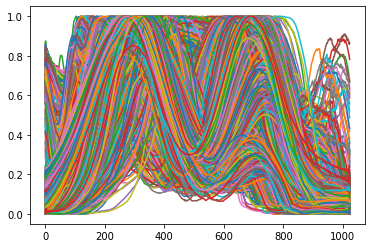

In [25]:
x = features['11_z'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(x.shape[0]):
    plt.plot(x[i, :])

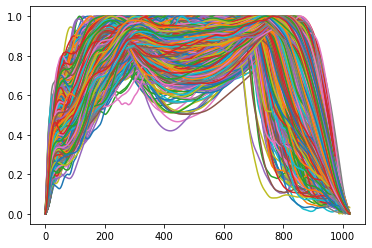

In [26]:
y = target['fz'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(y.shape[0]):
    plt.plot(y[i, :])

In [27]:
i

1843

In [28]:
features.shape

(1888256, 36)

In [29]:
from sklearn.decomposition import PCA

pca = PCA(3)

X = pca.fit_transform(features)

In [30]:
X.shape

(1888256, 3)

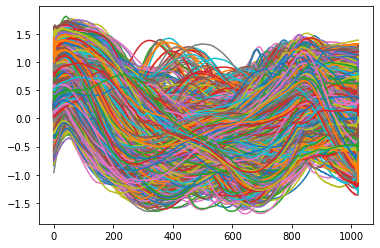

In [31]:
x = X[:, 2].reshape(-1, N_SAMPLES)
for i in range(x.shape[0]):
    plt.plot(x[i, :])

In [32]:
features

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,2_z,3_z,4_z,5_z,6_z,7_z,8_z,9_z,10_z,11_z
0,0.993815,0.993998,0.780790,0.762978,0.998144,0.999272,0.987459,0.997939,0.993687,0.716486,...,0.098127,0.039859,0.236491,0.084922,0.024491,0.012799,0.178445,0.005617,0.109636,0.094613
1,1.000000,1.000000,0.772150,0.753863,0.995182,1.000000,0.997526,1.000000,0.998462,0.724733,...,0.071013,0.012555,0.217229,0.056407,0.009669,0.002686,0.164591,0.000000,0.113841,0.099107
2,0.981804,0.982119,0.782180,0.764827,0.992382,0.992446,0.974054,0.988576,0.986760,0.708794,...,0.121106,0.067490,0.264108,0.100586,0.038992,0.023904,0.192032,0.016704,0.108506,0.095415
3,0.998765,0.998804,0.764574,0.745929,0.989619,0.996376,1.000000,0.997023,1.000000,0.728622,...,0.058498,0.001612,0.214601,0.036254,0.004494,0.000000,0.159409,0.001544,0.116677,0.103150
4,0.978451,0.978902,0.775753,0.758244,0.987143,0.987631,0.974527,0.985135,0.987093,0.711576,...,0.115299,0.062080,0.265029,0.086049,0.037681,0.024495,0.190487,0.020125,0.110482,0.098431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888251,0.094126,0.242532,0.104651,0.338951,0.038869,0.011807,0.452503,0.093864,0.183549,0.707066,...,0.933231,0.838907,0.726811,0.753313,0.402861,0.012017,0.010170,0.249253,0.309915,0.221147
1888252,0.075134,0.230399,0.083644,0.344109,0.039793,0.008714,0.453657,0.089654,0.178677,0.703138,...,0.950207,0.854566,0.741079,0.765629,0.410767,0.009713,0.008098,0.253719,0.315582,0.225378
1888253,0.163846,0.305926,0.169056,0.310513,0.036016,0.013592,0.455456,0.109754,0.203758,0.732352,...,0.933218,0.774201,0.671526,0.708361,0.371826,0.019449,0.016653,0.229582,0.285623,0.204113
1888254,0.000000,0.169108,0.000000,0.370316,0.045335,0.000000,0.455842,0.071696,0.157135,0.682096,...,1.000000,0.926384,0.804168,0.819529,0.445255,0.000000,0.000000,0.274217,0.341437,0.244325
